#DATASET
UTKFace dataset is a large-scale face dataset with long age span (range from 0 to 116 years old). The dataset consists of over 20,000 face images with annotations of age, gender, and ethnicity. The images cover large variation in pose, facial expression, illumination, occlusion, resolution, etc. This dataset could be used on a variety of tasks, e.g., face detection, age estimation, age progression/regression, landmark localization, etc.

https://www.kaggle.com/datasets/jangedoo/utkface-new/data

#Extracting dataset from ZipFile

In [1]:
#import zipfile module
from zipfile import ZipFile

with ZipFile('dataset.zip', 'r') as f:
  f.extractall()

#Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model

#Saving filenames in an array

In [3]:
path = Path("/content/UTKFace")
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))

In [4]:
print(len(filenames))
print(filenames[:3])

23598
['14_1_2_20170102234329485.jpg.chip.jpg', '31_1_4_20170112235052769.jpg.chip.jpg', '4_1_4_20161221193328366.jpg.chip.jpg']


#Splitting image name, gender, age from filename

In [5]:
np.random.seed(10)
np.random.shuffle(filenames)

age_labels, gender_labels, image_path = [], [], []

for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    age_labels.append(temp[0])
    gender_labels.append(temp[1])

#Making a dataframe

In [6]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_path, age_labels, gender_labels

In [7]:
gender_dict = {0:"Male",1:"Female"}

In [8]:
df = df.astype({'age':'float32', 'gender': 'int32'})

In [9]:
print(df.dtypes)

image      object
age       float32
gender      int32
dtype: object


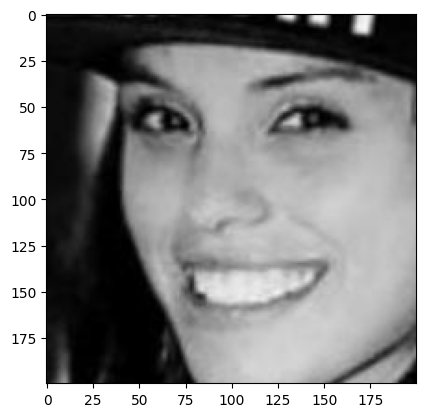

In [10]:
img = Image.open("UTKFace/"+df.image[1])
plt.imshow(img)

<ipython-input-11-36725a16e635>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.age)


<Axes: xlabel='age', ylabel='Density'>

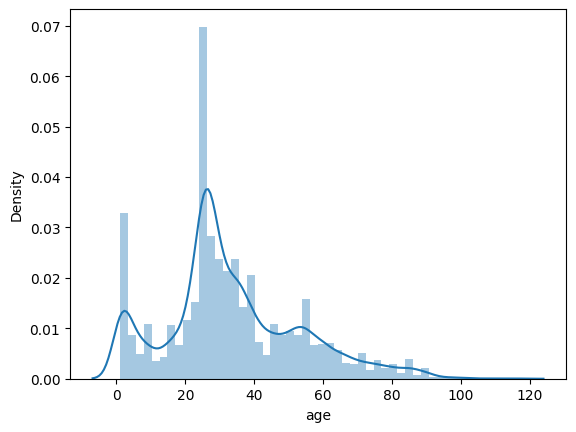

In [11]:
sns.distplot(df.age)

#Displaying 20 rows from dataframe

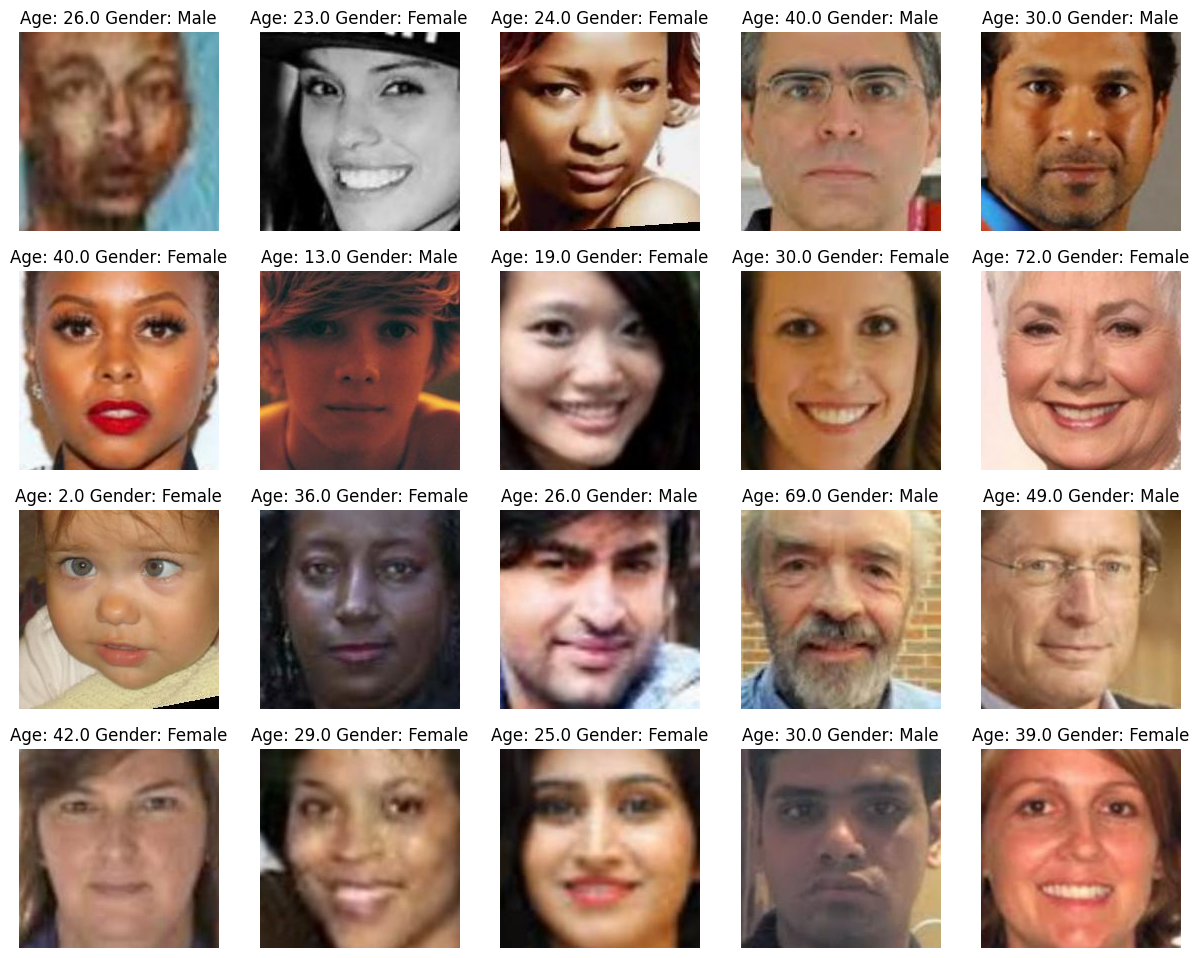

In [12]:
files = df.iloc[0:20]
plt.figure(figsize=(15,15))
for index, file, age, gender in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img("UTKFace/"+file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

#Splitting into training and test set

In [13]:
train, test = train_test_split(df, test_size=0.85, random_state=42)

* x_train = []: This initializes an empty list x_train which will store the processed image data.
*   for file in train.image:: This loop iterates over each file in the train.image list
*   img = load_img("UTKFace/" + file, grayscale=True): This line loads an image specified by the filename file from the "UTKFace/" directory. The grayscale=True argument ensures that the image is loaded in grayscale mode.
*  img = img.resize((128, 128), Image.ANTIALIAS): Here, the loaded image (img) is resized to a new shape of (128, 128)
*img = np.array(img): This converts the image (img) into a NumPy array, which represents the pixel values of the image.
*x_train.append(img): The NumPy array img is appended to the x_train list. After this loop completes, x_train will contain NumPy arrays representing the processed images.


In [14]:
#converting Image to numpy array (extracting feature)
x_train = []
for file in train.image:
    img = load_img("UTKFace/"+file, grayscale=True)
    img = img.resize((128,128), Image.ANTIALIAS)
    img = np.array(img)
    x_train.append(img)

x_train = np.array(x_train)

x_train = x_train.reshape(len(x_train), 128,128,1)

/usr/local/lib/python3.10/dist-packages/keras/src/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(
<ipython-input-14-01901eb87d5d>:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((128,128), Image.ANTIALIAS)


* / 255: This operation divides each pixel value in x_train by 255. This step is known as normalization or scaling, where the pixel values are scaled to be between 0 and 1. In image data, pixel values typically range from 0 to 255 (for grayscale images), so dividing by 255 ensures that the pixel values are in the range [0, 1], which is a common practice for neural network models to improve convergence and training stability.

In [15]:
x_train = x_train/255
y_gender = np.array(train.gender)
y_age = np.array(train.age)

* 128 (first value): This indicates the height of each input image in pixels.
* 128 (second value): This indicates the width of each input image in pixels.
* 1 (third value): This represents the number of channels or depth of each input image. In this case, 1 indicates that the input images are grayscale.

In [16]:
input_size = (128,128,1)

* Conv2D(filters, kernel_size, activation='relu', kernel_initializer=glorot_uniform(seed=0)): These lines define convolutional layers with specific configurations:
* filters: Number of filters (or kernels) to use in the convolutional layer.
* kernel_size: Size of the convolutional kernel (e.g., (3, 3) represents a 3x3 kernel).
* activation='relu': Rectified Linear Unit (ReLU) activation function is used after each convolution operation.
* kernel_initializer=glorot_uniform(seed=0): Glorot uniform initializer is used to initialize the weights of the convolutional filters.
* BatchNormalization(axis=3): Batch normalization layer is applied after the convolutional layer to normalize the activations and accelerate training.
* MaxPooling2D((pool_size)): Max pooling layer is applied to downsample the feature maps spatially.
* Dense(units, activation='relu'): These layers are fully connected (dense) layers with specific configurations:
* units: Number of neurons in the layer.
* activation='relu': Rectified Linear Unit (ReLU) activation function is used.

* Dropout(rate): Dropout layers with a dropout rate of 0.4 (40%) are applied to the outputs of the dense layers to prevent overfitting during training.

* Dense(1, activation='sigmoid', name='gender_output'): This dense layer with sigmoid activation function produces the gender_output prediction (binary classification).
* Dense(1, activation='relu', name='age_output'): This dense layer with relu activation function produces the age_output prediction (regression).

In [17]:
inputs = Input((input_size))
X = Conv2D(64, (3, 3), activation='relu', kernel_initializer = glorot_uniform(seed=0))(inputs)
X = BatchNormalization(axis = 3)(X)
X = MaxPooling2D((3, 3))(X)

X = Conv2D(128, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

X = Conv2D(256, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)

X = Flatten()(X)

dense_1 = Dense(256, activation='relu')(X)
dense_2 = Dense(256, activation='relu' )(X)
dense_3 = Dense(128, activation='relu' )(dense_2)
dropout_1 = Dropout(0.4)(dense_1)
dropout_2 = Dropout(0.4)(dense_3)
output_1 = Dense(1,activation='sigmoid', name='gender_output')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_output')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1,output_2])

* Loss Functions:
loss=['binary_crossentropy', 'mae']: The loss parameter specifies the loss functions to be used for each output of the model. In this case:
'binary_crossentropy': This loss function is typically used for binary classification tasks (like predicting gender in this model).
* 'mae' (Mean Absolute Error): This loss function is used for the regression task (like predicting age in this model).
Since the model has two output branches (gender_output and age_output), we specify a list of loss functions, one for each output.
* Optimizer:
optimizer='adam': The optimizer parameter specifies the optimization algorithm to use during training. Here, 'adam' refers to the Adam optimizer, which is an adaptive learning rate optimization algorithm.
* Metrics:
metrics=['accuracy']: The metrics parameter specifies the evaluation metrics to be used to monitor the training and validation performance of the model. In this case:
* 'accuracy': This metric computes the accuracy of the model predictions for the binary classification task (gender prediction).

In [18]:
model.compile(loss=['binary_crossentropy','mae'], optimizer='adam', metrics=['accuracy'])

In [19]:
model_history = model.fit(x=x_train, y=[y_gender, y_age], batch_size = 10, epochs=20, validation_split= 0.1)

Epoch 1/20
319/319 [==============================] - 295s 907ms/step - loss: 15.7702 - gender_output_loss: 0.6875 - age_output_loss: 15.0828 - gender_output_accuracy: 0.6863 - age_output_accuracy: 0.0396 - val_loss: 24.4303 - val_gender_output_loss: 0.6133 - val_age_output_loss: 23.8170 - val_gender_output_accuracy: 0.7599 - val_age_output_accuracy: 0.0367
Epoch 2/20
319/319 [==============================] - 275s 862ms/step - loss: 12.4438 - gender_output_loss: 0.4792 - age_output_loss: 11.9647 - gender_output_accuracy: 0.7805 - age_output_accuracy: 0.0204 - val_loss: 19.0055 - val_gender_output_loss: 0.4665 - val_age_output_loss: 18.5389 - val_gender_output_accuracy: 0.8136 - val_age_output_accuracy: 0.0028
Epoch 3/20
319/319 [==============================] - 286s 897ms/step - loss: 11.0866 - gender_output_loss: 0.3982 - age_output_loss: 10.6884 - gender_output_accuracy: 0.8122 - age_output_accuracy: 0.0110 - val_loss: 15.1775 - val_gender_output_loss: 0.3842 - val_age_output_loss:

#Making single predictions

* model.predict(x_train[index].reshape(1, 128, 128, 1)): This line uses the trained model to make predictions (pred) for the image at index. The x_train[index] image is reshaped to match the model's input shape (1, 128, 128, 1) (batch size of 1, image dimensions of 128x128, and 1 channel for grayscale).
* pred[0][0][0]: This retrieves the predicted gender output from pred (first output of the model), which is a probability value. The round() function is used to round the probability value to the nearest integer (0 or 1), corresponding to predicted gender category index.
* gender_dict[round(pred[0][0][0])]: This looks up the predicted gender category (0 or 1) in gender_dict to get the corresponding gender label (e.g., 'Male' or 'Female').
* pred[1][0][0]: This retrieves the predicted age output from pred (second output of the model), which is a regression value representing the predicted age.
* round(pred[1][0][0]): This rounds the predicted age value to the nearest integer for display.


In [47]:
my = load_img("/content/mypic.jpeg", grayscale=True)
my = my.resize((128,128), Image.ANTIALIAS)
my = np.array(my)
my=my.reshape(1,128,128,1)
my = my/255





<ipython-input-47-a34946e7c842>:2: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  my = my.resize((128,128), Image.ANTIALIAS)


1/1 [==============================] - 0s 40ms/step
Prediction: Gender =  Male  Age =  30


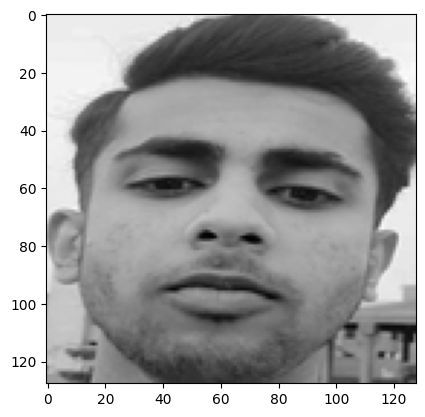

In [48]:
pred = model.predict(my.reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(my.reshape(128,128), cmap='gray')

Original: Gender =  Male  Age =  2.0
1/1 [==============================] - 0s 209ms/step
Prediction: Gender =  Male  Age =  4


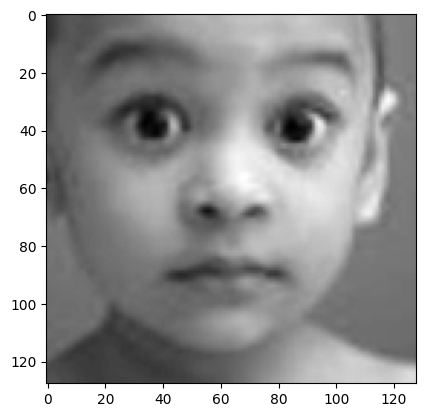

In [20]:
index=50
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')

Original: Gender =  Male  Age =  40.0
1/1 [==============================] - 0s 35ms/step
Prediction: Gender =  Male  Age =  39


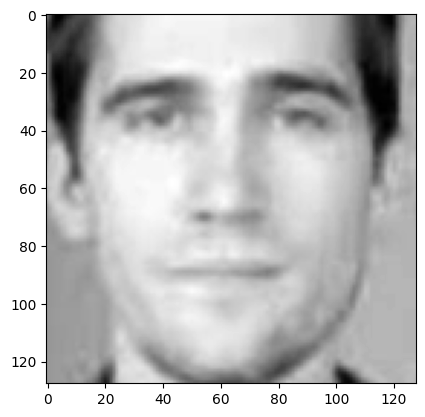

In [21]:
index=20
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')

Original: Gender =  Male  Age =  62.0
1/1 [==============================] - 0s 53ms/step
Prediction: Gender =  Male  Age =  57


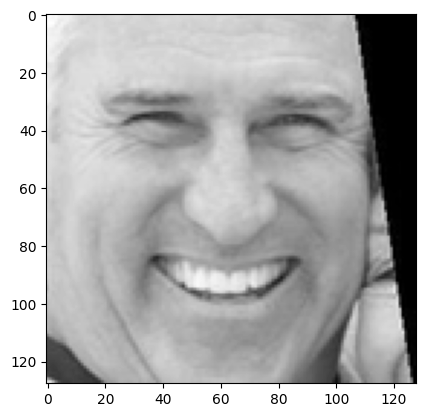

In [22]:
index=1500
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')